## Regression Analysis with Keras

In [70]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('seaborn')

SEED = 42
np.random.seed(SEED)
tf.set_random_seed(SEED)

from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import Sequence
from keras.regularizers import l2
from keras import optimizers

### Loading the Data

In [58]:
def load_data(path='abalone.h5'):
    with h5py.File(path, 'r') as handle:
        return np.array(handle['data']), list(column.decode('utf-8') for column in handle['columns'])
    
data, columns = load_data()
columns

['Sex',
 'Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Shucked weight',
 'Viscera weight',
 'Shell weight',
 'Rings']

### The Data at a Glance

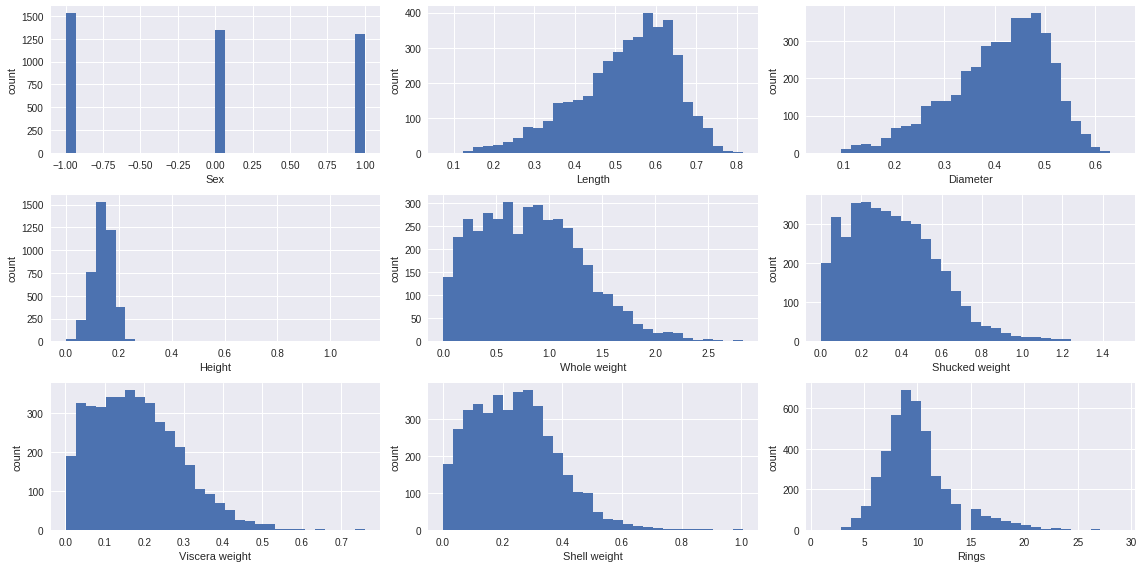

In [59]:
def plot_bins(data, columns):
    features = data.shape[1]
    figure, axis = plt.subplots(3, features // 3, figsize=(16, 8))
    axis = np.array(axis).flatten()
    
    for i, variable in enumerate(columns):
        axis[i].hist(data[:, i], bins=30)
        axis[i].set_xlabel(variable)
        axis[i].set_ylabel('count')
        
    plt.tight_layout()
    plt.show()
    
plot_bins(data, columns)

### Data Preprocessing

In [60]:
def split_and_preprocess(data, train_fraction=3.0/4.0):    
    split_point = int(data.shape[0] * train_fraction)
    
    # split the data in train, test and corresponding labels
    label_index = -1
    train_labels, test_labels = data[:split_point, label_index], data[split_point:, label_index]
    train, test = data[:split_point, :label_index], data[split_point:, :label_index]
    
    # calculate the mean and standard deviation for each feature for normalization
    mean, sigma = train.mean(axis=0), train.std(axis=0)
    # do not normalize the categorical 'sex' column
    mean[0], sigma[0] = 0.0, 1.0
    
    return (train - mean) / sigma, train_labels, (test - mean) / sigma, test_labels
    
train_data, train_labels, test_data, test_labels = split_and_preprocess(data)

### Building an Appropriate Network

In [61]:
def build_model(data):
    model = Sequential()
    
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.1), input_shape=(data.shape[1],)))
    model.add(Dense(5, activation='tanh', kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer=optimizers.Nadam(lr=1e-4), loss='mae')
    
    return model

model = build_model(train_data)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 20)                180       
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 105       
_________________________________________________________________
dropout_7 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 6         
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


### Tracking the Training Progress

In [62]:
class TrainingHistory(Callback):
    """
    Class for tracking the training progress/history of the neural network. Implements the keras.Callback interface.
    """
    def on_train_begin(self, logs):
        self.loss = []
        self.validation_loss = []
            
    def on_epoch_end(self, _, logs):
        """
        Callback invoked after each training batch.
        Should track the training loss and accuracy in the respective members.

        Parameters
        ----------
        _ : int
            unused, int corresponding to the batch number
        logs : dict{str -> float}
            a dictionary mapping from the observed quantity to the actual valu
        """
        if 'loss' in logs:
            self.loss.append(logs['loss'])
        if 'val_loss' in logs:
            self.validation_loss.append(logs['val_loss'])

### Training the Model

In [63]:
def train_model(model, train_data, train_labels, test_data, test_labels, epochs=500, batch_size=32):
    history = TrainingHistory()
    model.fit(
        train_data, train_labels, validation_data=(test_data, test_labels),
        epochs=epochs, shuffle=True, callbacks=[history]
    )
    
    return history
    
history = train_model(model, train_data, train_labels, test_data, test_labels)

Train on 3132 samples, validate on 1045 samples
Epoch 1/500
3132/3132 [==============================] - 0s 140us/step - loss: 12.0347 - val_loss: 12.0421
Epoch 2/500
3132/3132 [==============================] - 0s 32us/step - loss: 11.8646 - val_loss: 11.8814
Epoch 3/500
3132/3132 [==============================] - 0s 32us/step - loss: 11.7103 - val_loss: 11.7233
Epoch 4/500
3132/3132 [==============================] - 0s 33us/step - loss: 11.5579 - val_loss: 11.5664
Epoch 5/500
3132/3132 [==============================] - 0s 34us/step - loss: 11.3942 - val_loss: 11.4110
Epoch 6/500
3132/3132 [==============================] - 0s 33us/step - loss: 11.2388 - val_loss: 11.2570
Epoch 7/500
3132/3132 [==============================] - 0s 33us/step - loss: 11.0839 - val_loss: 11.1038
Epoch 8/500
3132/3132 [==============================] - 0s 41us/step - loss: 10.9389 - val_loss: 10.9509
Epoch 9/500
3132/3132 [==============================] - 0s 45us/step - loss: 10.7908 - val_loss: 10.79

3132/3132 [==============================] - 0s 30us/step - loss: 4.2924 - val_loss: 4.2735
Epoch 79/500
3132/3132 [==============================] - 0s 28us/step - loss: 4.2458 - val_loss: 4.2241
Epoch 80/500
3132/3132 [==============================] - 0s 32us/step - loss: 4.2156 - val_loss: 4.1765
Epoch 81/500
3132/3132 [==============================] - 0s 32us/step - loss: 4.1726 - val_loss: 4.1277
Epoch 82/500
3132/3132 [==============================] - 0s 30us/step - loss: 4.1586 - val_loss: 4.0794
Epoch 83/500
3132/3132 [==============================] - 0s 30us/step - loss: 4.0993 - val_loss: 4.0337
Epoch 84/500
3132/3132 [==============================] - 0s 31us/step - loss: 4.0224 - val_loss: 3.9861
Epoch 85/500
3132/3132 [==============================] - 0s 29us/step - loss: 3.9948 - val_loss: 3.9390
Epoch 86/500
3132/3132 [==============================] - 0s 32us/step - loss: 3.9575 - val_loss: 3.8926
Epoch 87/500
3132/3132 [==============================] - 0s 29us/st

3132/3132 [==============================] - 0s 31us/step - loss: 2.5996 - val_loss: 2.1333
Epoch 156/500
3132/3132 [==============================] - 0s 31us/step - loss: 2.6194 - val_loss: 2.1270
Epoch 157/500
3132/3132 [==============================] - 0s 28us/step - loss: 2.6202 - val_loss: 2.1192
Epoch 158/500
3132/3132 [==============================] - 0s 28us/step - loss: 2.6374 - val_loss: 2.1103
Epoch 159/500
3132/3132 [==============================] - 0s 28us/step - loss: 2.6052 - val_loss: 2.1030
Epoch 160/500
3132/3132 [==============================] - 0s 28us/step - loss: 2.5822 - val_loss: 2.0972
Epoch 161/500
3132/3132 [==============================] - 0s 30us/step - loss: 2.6078 - val_loss: 2.0904
Epoch 162/500
3132/3132 [==============================] - 0s 29us/step - loss: 2.5738 - val_loss: 2.0863
Epoch 163/500
3132/3132 [==============================] - 0s 29us/step - loss: 2.5427 - val_loss: 2.0781
Epoch 164/500
3132/3132 [==============================] - 0

3132/3132 [==============================] - 0s 31us/step - loss: 2.3832 - val_loss: 1.8701
Epoch 233/500
3132/3132 [==============================] - 0s 29us/step - loss: 2.3927 - val_loss: 1.8673
Epoch 234/500
3132/3132 [==============================] - 0s 30us/step - loss: 2.4038 - val_loss: 1.8658
Epoch 235/500
3132/3132 [==============================] - 0s 30us/step - loss: 2.3939 - val_loss: 1.8661
Epoch 236/500
3132/3132 [==============================] - 0s 30us/step - loss: 2.3728 - val_loss: 1.8668
Epoch 237/500
3132/3132 [==============================] - 0s 34us/step - loss: 2.3819 - val_loss: 1.8653
Epoch 238/500
3132/3132 [==============================] - 0s 33us/step - loss: 2.3878 - val_loss: 1.8656
Epoch 239/500
3132/3132 [==============================] - 0s 30us/step - loss: 2.4060 - val_loss: 1.8634
Epoch 240/500
3132/3132 [==============================] - 0s 34us/step - loss: 2.4235 - val_loss: 1.8604
Epoch 241/500
3132/3132 [==============================] - 0

3132/3132 [==============================] - 0s 31us/step - loss: 2.2827 - val_loss: 1.8080
Epoch 310/500
3132/3132 [==============================] - 0s 28us/step - loss: 2.2885 - val_loss: 1.8051
Epoch 311/500
3132/3132 [==============================] - 0s 31us/step - loss: 2.3020 - val_loss: 1.8072
Epoch 312/500
3132/3132 [==============================] - 0s 30us/step - loss: 2.2876 - val_loss: 1.8074
Epoch 313/500
3132/3132 [==============================] - 0s 29us/step - loss: 2.2963 - val_loss: 1.8075
Epoch 314/500
3132/3132 [==============================] - 0s 41us/step - loss: 2.3094 - val_loss: 1.8081
Epoch 315/500
3132/3132 [==============================] - 0s 32us/step - loss: 2.3404 - val_loss: 1.8109
Epoch 316/500
3132/3132 [==============================] - 0s 30us/step - loss: 2.3303 - val_loss: 1.8089
Epoch 317/500
3132/3132 [==============================] - 0s 29us/step - loss: 2.2676 - val_loss: 1.8049
Epoch 318/500
3132/3132 [==============================] - 0

3132/3132 [==============================] - 0s 30us/step - loss: 2.2283 - val_loss: 1.7795
Epoch 387/500
3132/3132 [==============================] - 0s 31us/step - loss: 2.2630 - val_loss: 1.7797
Epoch 388/500
3132/3132 [==============================] - 0s 29us/step - loss: 2.2483 - val_loss: 1.7824
Epoch 389/500
3132/3132 [==============================] - 0s 30us/step - loss: 2.2411 - val_loss: 1.7849
Epoch 390/500
3132/3132 [==============================] - 0s 28us/step - loss: 2.1943 - val_loss: 1.7797
Epoch 391/500
3132/3132 [==============================] - 0s 28us/step - loss: 2.2158 - val_loss: 1.7762
Epoch 392/500
3132/3132 [==============================] - 0s 29us/step - loss: 2.2375 - val_loss: 1.7743
Epoch 393/500
3132/3132 [==============================] - 0s 28us/step - loss: 2.2443 - val_loss: 1.7738
Epoch 394/500
3132/3132 [==============================] - 0s 30us/step - loss: 2.2093 - val_loss: 1.7773
Epoch 395/500
3132/3132 [==============================] - 0

3132/3132 [==============================] - 0s 33us/step - loss: 2.1704 - val_loss: 1.7637
Epoch 464/500
3132/3132 [==============================] - 0s 28us/step - loss: 2.1839 - val_loss: 1.7595
Epoch 465/500
3132/3132 [==============================] - 0s 29us/step - loss: 2.1632 - val_loss: 1.7560
Epoch 466/500
3132/3132 [==============================] - 0s 31us/step - loss: 2.1721 - val_loss: 1.7577
Epoch 467/500
3132/3132 [==============================] - 0s 28us/step - loss: 2.1854 - val_loss: 1.7601
Epoch 468/500
3132/3132 [==============================] - 0s 30us/step - loss: 2.1709 - val_loss: 1.7530
Epoch 469/500
3132/3132 [==============================] - 0s 28us/step - loss: 2.1975 - val_loss: 1.7562
Epoch 470/500
3132/3132 [==============================] - 0s 28us/step - loss: 2.1526 - val_loss: 1.7587
Epoch 471/500
3132/3132 [==============================] - 0s 31us/step - loss: 2.1582 - val_loss: 1.7550
Epoch 472/500
3132/3132 [==============================] - 0

### Visualization of the Training Progress

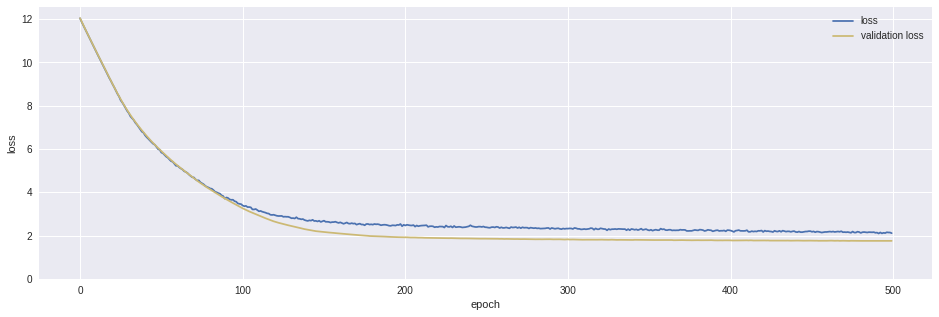

In [73]:
def plot_history(history):
    figure, axis = plt.subplots(1, 1, figsize=(16, 5))
    
    # plot the training loss and accuracy
    axis.set_xlabel('epoch')
    axis.set_ylabel('loss')
    
    epochs = np.arange(len(history.loss))
    axis.plot(epochs, history.loss, color='C0', label='loss')
    axis.plot(epochs, history.validation_loss, color='C4', label='validation loss')
    axis.set_ylim(bottom=0.0)
    
    # display a legend
    axis.legend(loc=1)
    plt.show()

plot_history(history)

### Very Brief Evaluation of the Model

In [77]:
print('MAE of the prediction:', model.evaluate(test_data, test_labels))
print('Standard deviation of the labels:', np.concatenate([train_labels, test_labels]).std())

1045/1045 [==============================] - 0s 20us/step
MAE of the prediction: 1.7527956922088515
Standard deviation of the labels: 3.2237830658212117


### References